In [1]:
import json
import torch
import numpy as np
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import InterpolationMode


import sys
from pathlib import Path

notebook_path = Path().resolve()
project_root = notebook_path.parent
sys.path.append(str(project_root))

from utils import DiffusionModelPipeline, ImagePromptDataset

c:\Users\wolfg\OneDrive\Documents\Projects\OMI\my-omi-code\omi_training_code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initialize Model

Observations
- inC - needs to be .vae.config.latent_channels


In [2]:
dit_params = {
    'channels': 384,
    'nBlocks': 8,
    'nHeads': 8,
    'conditionC': 384,
    'patchSize': 1,
    'text_embed_dim': 512,
}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiffusionModelPipeline(dit_params = dit_params,
                       emaStrength= 0.999,
                       device=device)

In [4]:
##Hacky work around - will fix later
model.tokenizer.name_or_path = 't5-base'
model.text_encoder.config.name_or_path = 't5-base'
model.vae.config._name_or_path = 'flux_schnell_vae'

In [5]:
print(f"total trainable parameters: {model.total_parameters}, in mil {model.total_parameters/1e6} in bil {model.total_parameters/1e9}") 

total trainable parameters: 47641152, in mil 47.641152 in bil 0.047641152


## Test Gen

In [7]:
image = model(['a beautiful sunset over the ocean', 'some other noise'], num_inference_steps=50)

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\wolfg\OneDrive\Documents\Projects\OMI\my-omi-code\omi_training_code\utils\dit.py:105: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attnOutput = torch.nn.functional.scaled_dot_product_attention(q, k, v)
100%|██████████| 50/50 [00:01<00:00, 45.00it/s]


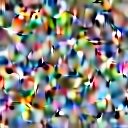

In [8]:
image[0]

In [9]:
image = model('a beautiful sunset over the ocean', num_inference_steps=50)


100%|██████████| 50/50 [00:00<00:00, 52.83it/s]


In [10]:
np_img = np.array(image[0])
print(np_img.shape)
#image shape should be what we expect to output

(128, 128, 3)


## Test Training

In [11]:
# dataset = load_dataset("openmodelinitiative/initial-test-dataset")
# dataset = load_dataset("laion/laion2B-en")
ds = load_dataset("svjack/pokemon-blip-captions-en-zh")

#to run on runpod I had to comment out lines 188/189 in usr/lib/local/pyhton/datasets/features/Image.py 

# ds = load_dataset("pcuenq/lsun-bedrooms")
split_ds = ds['train'].train_test_split(test_size=0.1, seed=42)


In [12]:
transform = transforms.Compose([
    # transforms.Resize((512, 512), interpolation=InterpolationMode.LANCZOS),
    transforms.Resize((128, 128), interpolation=InterpolationMode.LANCZOS),
    transforms.ToTensor(),  # Converts to tensor and scales pixel values to [0, 1]
])

In [13]:
# Create the custom dataset
train_dataset = ImagePromptDataset(split_ds["train"], transform=transform)
val_dataset = ImagePromptDataset(split_ds["test"], transform=transform)


In [14]:
# Training DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,  # Adjust based on your GPU memory
    shuffle=True,
    num_workers=0  # Set to 0 if you encounter issues on Windows
)

# Validation DataLoader
val_dataloader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0
)

In [15]:
next(iter(train_dataloader))

[tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],
 
 
         [[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1

In [16]:
history = model.train(train_dataloader,
            val_dataloader,
            epochs = 10000,
            log_interval= 100,
            save_interval= 1000,
            output_dir= 'pokemon_training_test',
            patience= 1000,
            visualize=True,
            visualize_interval= 100,
            visualize_prompt= ['A green pokemon with a leaf on its head',
                      'a red pokemon with a fire on its tail',
                      'a yellow cartoon character with a big smile',
                      'a cartoon frog character with a crown',],
            num_inference_steps= 10)

changing optimizer to AdamW and added rectified flow 


100%|██████████| 10/10 [00:00<00:00, 53.32it/s]                                           


In [ ]:
# Save history 
with open('history.json', 'w') as f:
    json.dump(history, f)
